# Análise de Componentes Principais

Autor: João Tedeschi

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ITalents/CD-Introducao-a-Ciencia-de-dados)

Caso precise instalar alguma biblioteca, utilize o comando `!pip install pandas numpy matplotlib seaborn duckdb plotly` numa célula de python no Jupyter Notebook.

In [ ]:
!git clone https://github.com/ITalents/CD-Introducao-a-Ciencia-de-dados.git

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Tratamento de Dados Ausentes

Dados ausentes (``NaN``, ``NULL``) podem significar muitas coisas diferentes. Por exemplo, pode significar:
- o dado não existe ou que ele não foi coletado;
- o dado foi perdido ou corrompido;
- o dado existe mas não foi inserido no conjunto de dados;  

Tendo isso em mente, vamos ver algumas técnicas para tratar dados ausentes.

## Identificação de Dados Ausentes

Podemos identificar dados ausentes usando a função ``isnull()`` do pandas. Essa função retorna ``True`` se o valor for ausente e ``False`` caso contrário.

```python   
import pandas as pd
import numpy as np

df = pd.DataFrame({'A': [1, 2, np.nan, 4],
                   'B': [5, np.nan, np.nan, 8],
                   'C': [10, 20, 30, 40]})
df

df.isnull()
```

## Remoção de Dados Ausentes

Podemos remover os dados ausentes usando a função ``dropna()`` do pandas. Essa função remove todas as linhas que contém dados ausentes.

```python
df.dropna()
```

Podemos remover as colunas que contém dados ausentes usando o parâmetro ``axis=1``.

```python
df.dropna(axis=1)
```

Podemos remover as linhas que contém todos os dados ausentes usando o parâmetro ``how='all'``.

```python
df.dropna(how='all')
```

Podemos remover as linhas que contém pelo menos 2 dados ausentes usando o parâmetro ``thresh=2``.

```python
df.dropna(thresh=2)
```

## Preenchimento de Dados Ausentes

Podemos preencher os dados ausentes usando a função ``fillna()`` do pandas. Essa função preenche os dados ausentes com o valor passado como parâmetro.

```python
df.fillna(0)
```

Podemos preencher os dados ausentes com a média dos valores da coluna.

```python
df.fillna(df.mean())
```

E outras estratégias de preenchimento.

O metodo ``ffill`` preenche os dados ausentes com o último valor válido.
```python
df.fillna(method='ffill')
```

O método ``bfill`` preenche os dados ausentes com o próximo valor válido.
```python
df.fillna(method='bfill')
```

Agora, vamos ler o conjunto de dados de churn da Telco

In [ ]:
# Importando a biblioteca DuckDB
import duckdb
import glob

# Conectando-se ao banco de dados em memória do DuckDB
duckdb_conn = duckdb.connect(database=':memory:', read_only=False)

# Looping através de todos os arquivos .xlsx na pasta 'dados'
for arquivo in glob.glob('/content/CD-Introducao-a-Ciencia-de-dados/EDA/dados/*.xlsx'):
    # Imprimindo o nome do arquivo atual
    print(arquivo)
    
    # Extraindo o nome do arquivo sem a extensão e usando como nome da tabela no banco de dados
    nome_arquivo = arquivo.split('/')[-1].split('.')[0].split('_')[-1]
    
    # Lendo o arquivo Excel com o pandas e registrando-o como uma tabela no DuckDB
    dataframe = pd.read_excel(arquivo)
    duckdb_conn.register('tb_'+nome_arquivo, dataframe)

# Criando uma query para extrair os dados de todas as tabelas
# Excluindo a coluna 'Count' das tabelas

query = """
SELECT * EXCLUDE (Count) FROM tb_status
LEFT JOIN tb_services USING ("Customer ID")
LEFT JOIN tb_demographics USING ("Customer ID")
LEFT JOIN tb_location USING ("Customer ID")
LEFT JOIN tb_population USING ("Zip Code")
"""

# Executando a query e armazenando o resultado em um DataFrame
dataframe_telco = duckdb_conn.execute(query).fetch_df()

# o Método .head() exibe as 5 primeiras linhas do DataFrame
dataframe_telco.head()

In [4]:
colunas_drop = ['Quarter','Quarter_2','ID',  'Customer Status', 'Churn Reason', 'CLTV', 'Churn Value', 'Churn Label', 'Churn Score', 'Lat Long']

dataframe_eda = dataframe_telco.drop(columns=colunas_drop)
dataframe_eda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Satisfaction Score                 7043 non-null   int64  
 2   Churn Category                     1869 non-null   object 
 3   Referred a Friend                  7043 non-null   object 
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Offer                              3166 non-null   object 
 7   Phone Service                      7043 non-null   object 
 8   Avg Monthly Long Distance Charges  7043 non-null   float64
 9   Multiple Lines                     7043 non-null   object 
 10  Internet Service                   7043 non-null   object 
 11  Internet Type                      5517 non-null   objec

Vamos separar as variáveis numéricas das variáveis categóricas.

In [36]:
telco_num = dataframe_eda.select_dtypes(include=np.number)
telco_cat = dataframe_eda.drop(columns="Customer ID").select_dtypes(exclude=np.number)

numcols = telco_num.columns
catcols = telco_cat.columns

# Transformação de Dados

Por vezes, precisamos transformar os dados para que eles possam ser melhor utilizados em nossas análises. Por exemplo, podemos querer transformar os dados para que eles tenham uma [**Distribuição Normal**](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal) ou para que eles tenham uma escala similar.

## Normalização

A normalização é uma técnica que transforma os dados para média 0 e desvio padrão 1. Essa técnica é útil quando queremos que os dados tenham uma distribuição normal. 

Muito utilizada para reduzir a escala dos dados (variância) e para melhorar a convergência dos algoritmos de aprendizado de máquina e clusterização.

<!-- MathJax -->
__Normalização ou Standard Scaling__ 

$$ x_{norm} = \frac{x - \mu}{\sigma} $$

Onde $\mu$ é a média e $\sigma$ é o desvio padrão.

## Min-Max Scaling

O Min-Max Scaling é uma técnica que transforma os dados para que eles fiquem entre 0 e 1. Essa técnica é útil quando queremos que os dados tenham uma distribuição uniforme.

__Min-Max Scaling__

$$ x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}} $$

Onse $x_{min}$ é o menor valor e $x_{max}$ é o maior valor.


## Transformação Logarítmica

Muias vezes, os dados possuem uma distribuição assimétrica. Nesses casos, podemos aplicar uma transformação logarítmica para que os dados fiquem mais próximos de uma distribuição normal.

<!-- MathJax -->
$$ x_{log} = log(x) $$



Vamos preencher os valores faltantes das variáveis numéricas com a média.

In [38]:
telco_num= telco_num.fillna('mean')

In [40]:
scaler = StandardScaler()
telco_num_scaled = scaler.fit_transform(telco_num)

pd.DataFrame(telco_num_scaled, columns=numcols).head()

Satisfaction Score  Number of Referrals  Tenure in Months   
0           -0.203836            -0.317185         -0.993743  \
1           -1.036080            -0.317185          0.187986   
2           -1.036080            -0.317185         -1.278988   
3           -1.868323            -0.650409         -0.871495   
4           -1.868323            -0.650409         -0.708498   

   Avg Monthly Long Distance Charges  Avg Monthly GB Download  Monthly Charge   
0                           1.676120                -0.172176        0.528063  \
1                          -1.076516                -0.319109        0.390134   
2                          -0.497116                 0.464533        0.189056   
3                          -0.735997                 0.415555        1.004999   
4                           0.398203                 0.415555        0.320338   

   Total Charges  Total Refunds  Total Extra Data Charges   
0      -0.726848      -0.248313                 -0.273300  \
1       0.259379      -0.248313                 -0.273300   
2      -0.975231      -0.248313                 -0.273300   
3      -0.511938      -0.248313                  4.506968   
4      -0.532237      -0.248313                 -0.273300   

   Total Long Distance Charges  Total Revenue       Age  Number of Dependents   
0                    -0.423221      -0.701668  1.641292              0.551874  \
1                    -0.608185       0.023728  1.999519              0.551874   
2                    -0.866784      -1.029196  1.760701              1.590583   
3                    -0.734242      -0.581706  1.880110              0.551874   
4                    -0.369064      -0.531738  1.103952             -0.486835   

   Zip Code  Latitude  Longitude  Population  
0 -1.843695 -0.872175   0.729456    1.585200  
1 -1.553385 -0.901401   0.806071    0.195046  
2 -1.489829 -0.973149   0.784995   -0.037663  
3 -1.013161 -0.806140   0.629754    1.655079  
4 -0.950144 -0.850676   0.858734    0.552100

Vamos preencher os valores faltantes das variáveis categóricas com a moda.

In [ ]:
telco_cat = telco_cat.fillna(telco_cat.mode().iloc[0])

Vamos transformar as variáveis categóricas em variáveis numéricas usando o One Hot Encoding. A técnica One Hot Encoding transforma cada categoria de uma variável categórica em uma nova variável numérica. Essa nova variável numérica recebe o valor 1 se a observação pertence à categoria ou 0 se não pertence.

Ele cria um vetor esparso, ou seja, um vetor com zeros em  todas as posições, exceto na posição que representa a categoria. Por exemplo, se a variável categórica tem 3 categorias, o One Hot Encoding cria 3 novas variáveis numéricas. Se a observação pertence à categoria 1, a primeira variável recebe o valor 1 e as outras recebem 0. Se a observação pertence à categoria 2, a segunda variável recebe o valor 1 e as outras recebem 0. Se a observação pertence à categoria 3, a terceira variável recebe o valor 1 e as outras recebem 0.

## Exemplo de One Hot Encoding:

Vamos juntar as variáveis numéricas e categóricas.


In [ ]:
telco_cat_encoded = pd.get_dummies(telco_cat)

A função `pd.get_dummies()` do pandas faz o One Hot Encoding das variáveis categóricas. Ela transforma cada categoria de uma variável categórica em uma nova variável numérica.


Existem outras formas de aplicar Encoding em variáveis categóricas. Você pode ler mais sobre isso [aqui](https://medium.com/mlearning-ai/category-encoders-c2a9bb192f0a) e usar a biblioteca [`category_encoders`](https://contrib.scikit-learn.org/category_encoders/).

# Análise por Componentes Principais (PCA)

A [Análise por Componentes Principais (PCA)](https://pt.wikipedia.org/wiki/An%C3%A1lise_de_componentes_principais) é uma técnica de redução de dimensionalidade. Ela é usada para reduzir o número de variáveis de um conjunto de dados. Ela é muito útil quando temos muitas variáveis e queremos reduzir o número de variáveis para facilitar a análise.

Colocando em termos práticos: imagine que você tem um conjunto de dados com 100 variáveis. Você quer fazer uma análise exploratória, mas é muito difícil analisar 100 variáveis. Então você usa o PCA para reduzir o número de variáveis para 2. Agora você pode fazer uma análise exploratória usando apenas 2 variáveis.

## Como funciona o PCA

Imagine que temos 100 variáveis que explicam o comportamento de um conjunto de dados. A Análise por Componentes combina estas variáveis em novas variáveis que explicam um percentual do comportamento do conjunto de dados. Essa é uma técnica de compressão de dados.

O PCA funciona da seguinte forma: ele cria novas variáveis que são combinações lineares das variáveis originais. Essas novas variáveis são chamadas de componentes principais. O PCA cria as novas variáveis de forma que a primeira nova variável tenha a maior variância possível, a segunda nova variável tenha a segunda maior variância possível, e assim por diante. A variância é uma medida de dispersão dos dados. Quanto maior a variância, mais os dados estão espalhados. Quanto menor a variância, mais os dados estão concentrados.


O primeiro componente principal é uma combinação linear das variáveis originais que tem a maior variância possível. O segundo componente principal é uma combinação linear das variáveis originais que tem a segunda maior variância possível. E assim por diante.

Essa combinação linear é feita de forma que os componentes principais sejam ortogonais entre si. Ou seja, os componentes principais são perpendiculares entre si. Isso é feito para que os componentes principais sejam independentes entre si.


A fórmula da combinação linear é a seguinte:

<!-- MathJax -->

$$ Z = a_1X_1 + a_2X_2 + ... + a_nX_n $$
Onde:
Z é o componente principal
a é o peso da variável
X é a variável original

O que significa o peso da variável? O peso da variável é um número que indica a importância da variável na combinação linear. Quanto maior o peso da variável, maior a importância dela na combinação linear. O peso da variável é calculado de forma que o componente principal tenha a maior variância possível.

Passo a Passo de como o PCA funciona:

1. Calcula a matriz de covariância das variáveis originais

2. Calcula os autovetores e autovalores da matriz de covariância

3. Ordena os autovalores em ordem decrescente

4. Escolhe os k autovetores que correspondem aos k maiores autovalores, onde k é o número de componentes principais que queremos


## Passo 1

Definição de Covariância:

A covariância é uma medida que indica o grau de interdependência entre duas variáveis. Ela indica como duas variáveis variam em conjunto. Se as variáveis variam da mesma forma, elas têm covariância positiva. Se as variáveis variam de forma contrária, elas têm covariância negativa. Se as variáveis não variam juntas, elas têm covariância zero.

<!-- MathJax -->

$$ cov(X,Y) = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{n-1} $$

Onde:

X e Y são as variáveis

n é o número de observações


Para se calcular uma matriz de covariância, é preciso calcular a covariância entre todas as variáveis. Se tivermos 3 variáveis, precisamos calcular a covariância entre as 3 variáveis. Se tivermos 4 variáveis, precisamos calcular a covariância entre as 4 variáveis. E assim por diante.

Imagine que temos 3 variáveis: X, Y e Z. A matriz de covariância é a seguinte:

<!-- MathJax -->

$$ \begin{bmatrix} cov(X,X) & cov(X,Y) & cov(X,Z) \\ cov(Y,X) & cov(Y,Y) & cov(Y,Z) \\ cov(Z,X) & cov(Z,Y) & cov(Z,Z) \end{bmatrix} $$

A matriz de covariância é uma matriz quadrada. Ela tem o mesmo número de linhas e colunas. A diagonal principal da matriz de covariância é formada pelas variâncias das variáveis. A diagonal principal é formada pelos elementos que estão na mesma linha e coluna. Os elementos que não estão na diagonal principal são as covariâncias entre as variáveis.

## Passo 2

Para se calcular autovetores e autovalores, a fórmula é a seguinte:

<!-- MathJax -->

$$ A\vec{v} = \lambda\vec{v} $$

Onde:

A é a matriz de covariância

v é o autovetor

λ é o autovalor

Fazendo o cálculo, temos:

<!-- MathJax -->

$$ (A - \lambda I)\vec{v} = 0 $$

Onde:
I é a matriz identidade

A matriz identidade é uma matriz quadrada que tem 1 na diagonal principal e 0 nos outros elementos.

Exemplo de matriz identidade:

<!-- MathJax -->

$$ \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

Como (A - λI)v = 0, então:

<!-- MathJax -->

$$ det(A - \lambda I) = 0 $$

Com isso obtemos o autovalor λ. Para cada autovalor, temos um autovetor correspondente.

## Passo 3

Ordena os autovalores em ordem decrescente

## Passo 4

Escolhe os autovetores correspondentes aos maiores autovalores. Esses autovetores são os componentes principais.


## Como usar o PCA

O PCA é uma técnica de redução de dimensionalidade. Ele é usado para reduzir o número de variáveis de um conjunto de dados. Ele é muito útil quando temos muitas variáveis altamente correlacionadas entre si e queremos reduzir o número de variáveis para facilitar a análise.

Se por ventura as variáveis não estiverem correlacionadas entre si, o PCA não vai funcionar. Por isso, é importante analisar a correlação entre as variáveis antes de usar o PCA.


## Exemplo

Vamos usar o PCA para reduzir o número de variáveis do conjunto de dados de serviços de telecomunicações. Primeiro, vamos importar as bibliotecas necessárias.
Depois, vamos transformar as variáveis categóricas em variáveis numéricas usando o One Hot Encoding.

In [ ]:
services = duckdb_conn.execute('''SELECT * FROM tb_services''').fetch_df()

services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Quarter                            7043 non-null   object 
 3   Referred a Friend                  7043 non-null   object 
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Offer                              3166 non-null   object 
 7   Phone Service                      7043 non-null   object 
 8   Avg Monthly Long Distance Charges  7043 non-null   float64
 9   Multiple Lines                     7043 non-null   object 
 10  Internet Service                   7043 non-null   object 
 11  Internet Type                      5517 non-null   objec

Vamos padronizar as variáveis numéricas normalizadas com as variáveis categóricas que foram transformadas com o One Hot Encoding. Juntamente com o Customer ID. E em seguida realizar o PCA.

In [49]:

df_analise = pd.DataFrame(np.concatenate((dataframe_eda[['Customer ID']],telco_num_scaled, telco_cat_encoded), axis=1))

df_analise.columns = ['Customer ID'] + list(numcols) + list(telco_cat_encoded.columns)

df_analise



Customer ID Satisfaction Score Number of Referrals Tenure in Months   
0     7495-OOKFY          -0.203836           -0.317185        -0.993743  \
1     4846-WHAFZ           -1.03608           -0.317185         0.187986   
2     0390-DCFDQ           -1.03608           -0.317185        -1.278988   
3     0094-OIFMO          -1.868323           -0.650409        -0.871495   
4     9947-OTFQU          -1.868323           -0.650409        -0.708498   
...          ...                ...                 ...              ...   
7038  8344-WFMFH           0.628407           -0.650409        -0.952994   
7039  9589-ABEPT          -0.203836            2.348606         1.491962   
7040  6888-SBYAI          -0.203836           -0.650409        -1.278988   
7041  3779-OSWCF          -0.203836            2.015382         1.573461   
7042  3662-FXJFO            1.46065           -0.650409         0.880723   

     Avg Monthly Long Distance Charges Avg Monthly GB Download Monthly Charge   
0                              1.67612               -0.172176       0.528063  \
1                            -1.076516               -0.319109       0.390134   
2                            -0.497116                0.464533       0.189056   
3                            -0.735997                0.415555       1.004999   
4                             0.398203                0.415555       0.320338   
...                                ...                     ...            ...   
7038                          0.303039                0.415555      -0.487295   
7039                         -1.286912               -0.025243       0.920247   
7040                          0.976955               -0.319109      -0.467354   
7041                         -0.701686                 0.12169       0.945174   
7042                         -0.785197               -1.004796      -1.471079   

     Total Charges Total Refunds Total Extra Data Charges  ...   
0        -0.726848     -0.248313                  -0.2733  ...  \
1         0.259379     -0.248313                  -0.2733  ...   
2        -0.975231     -0.248313                  -0.2733  ...   
3        -0.511938     -0.248313                 4.506968  ...   
4        -0.532237     -0.248313                  -0.2733  ...   
...            ...           ...                      ...  ...   
7038     -0.792711     -0.248313                  -0.2733  ...   
7039      1.844686     -0.248313                  -0.2733  ...   
7040     -0.983946     -0.248313                  -0.2733  ...   
7041      1.864809     -0.248313                  -0.2733  ...   
7042     -0.549271     -0.248313                  -0.2733  ...   

     City_Wrightwood City_Yermo City_Yorba Linda City_Yorkville   
0              False      False            False          False  \
1              False      False            False          False   
2              False      False            False          False   
3              False      False            False          False   
4              False      False            False          False   
...              ...        ...              ...            ...   
7038           False      False            False          False   
7039           False      False            False          False   
7040           False      False            False          False   
7041           False      False            False          False   
7042           False      False            False          False   

     City_Yountville City_Yreka City_Yuba City City_Yucaipa City_Yucca Valley   
0              False      False          False        False             False  \
1              False      False          False        False             False   
2              False      False          False        False             False   
3              False      False          False        False             False   
4              False      False          False        False             False   
...              ...        ...    

In [46]:
# Realizando a análise de componentes principais
pca = PCA(n_components=2)
pca.fit(df_analise.drop(columns='Customer ID'))

# Criando um DataFrame com os resultados
df_pca = pd.DataFrame(pca.transform(df_analise.drop(columns='Customer ID')), columns=['PC1', 'PC2'])

# Adicionando a coluna 'Customer ID' ao DataFrame
df_pca['Customer ID'] = df_analise['Customer ID']
df_pca['Churn'] = dataframe_telco['Churn Label']

# Exibindo as 5 primeiras linhas do DataFrame
df_pca.head()


PC1       PC2 Customer ID Churn
0 -0.722728 -2.470261  7495-OOKFY   Yes
1 -0.080065 -1.948190  4846-WHAFZ   Yes
2 -1.809257 -1.875416  0390-DCFDQ   Yes
3 -0.546284 -2.517778  0094-OIFMO   Yes
4 -1.217106 -2.227472  9947-OTFQU   Yes

Explicando o código acima:

O método `fit` do PCA calcula os componentes principais. O método `transform` do PCA transforma os dados originais usando os componentes principais. O método `fit_transform` do PCA calcula os componentes principais e transforma os dados originais usando os componentes principais.

O parâmetro `n_components` do PCA indica o número de componentes principais que queremos criar. Nesse caso, queremos criar 2 componentes principais.

Vamos visualizar os componentes principais criados pelo PCA, e como a distribuição dos dados ficou após a redução de dimensionalidade.

In [47]:
# Importando a biblioteca Plotly Express
import plotly.express as px

# Criando um gráfico de dispersão com os resultados da PCA
fig = px.scatter(df_pca, x='PC1', y='PC2', hover_data=['Customer ID'], color='Churn')

fig.show()



In [28]:
# como o gráfico não ficou muito bom, vamos tentar com 3 componentes
pca = PCA(n_components=3)
pca.fit(df_analise.drop(columns='Customer ID'))

# Criando um DataFrame com os resultados
df_pca = pd.DataFrame(pca.transform(df_analise.drop(columns='Customer ID')), columns=['PC1', 'PC2', 'PC3'])

# Adicionando a coluna 'Customer ID' ao DataFrame
df_pca['Customer ID'] = df_analise['Customer ID']
df_pca['Churn'] = dataframe_telco['Churn Label']

# Exibindo as 5 primeiras linhas do DataFrame

# Criando um gráfico de dispersão com os resultados da PCA
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', hover_data=['Customer ID'], color='Churn')
fig.show()


fig = px.scatter(df_pca, x='PC1', y='PC2', hover_data=['Customer ID'], color='Churn')

fig.show()

fig = px.scatter(df_pca, x='PC1', y='PC3', hover_data=['Customer ID'], color='Churn')

fig.show()

fig = px.scatter(df_pca, x='PC3', y='PC2', hover_data=['Customer ID'], color='Churn')

fig.show()


In [ ]:
# gráfico de explicação da variância por componente

# Criando um DataFrame com os resultados
df_pca_var = pd.DataFrame({'Componente': ['PC1', 'PC2', 'PC3'], 'Variância': pca.explained_variance_ratio_})

# Criando um gráfico de barras com os resultados
fig = px.bar(df_pca_var, x='Componente', y='Variância', color='Componente', text='Variância')

fig.show()

# Análise por Clusterização (K-Means)

A clusterização é uma técnica de aprendizado não supervisionado. Ela é usada para agrupar observações semelhantes em grupos, chamados de clusters. A clusterização é muito usada para segmentação de clientes. Por exemplo, imagine que você tem um conjunto de dados com informações de clientes. Você pode usar a clusterização para agrupar os clientes em grupos de clientes semelhantes. Isso é muito útil para fazer campanhas de marketing direcionadas para cada grupo de clientes.

## Como funciona a clusterização

1. O algoritmo inicializa os clusters/agrupamentos pelos centroides. O centroide é o ponto central de um cluster, com uma coordenada inicialmente aleatória. O algoritmo inicializa os centroides de forma que eles sejam o mais distante possível entre si. 

2. A distância é calculada entre cada observação e cada cluster. Cada observação é designada ao cluster mais próximo. 

A distância entre as observações é calculada usando uma métrica de distância. 
A métrica de distância mais usada é a distância euclidiana. 
A distância euclidiana é a distância entre dois pontos. Por exemplo, a distância entre os pontos A e B é dada pela seguinte fórmula:


$$d(A,B) = \sqrt{(x_A - x_B)^2 + (y_A - y_B)^2}$$

Onde $x_A$ e $y_A$ são as coordenadas do ponto A e $x_B$ e $y_B$ são as coordenadas do ponto B.

3. Os centroides são recalculados. O novo centroide é a média das observações do cluster.

4. Os passos 2 e 3 são repetidos até que os centroides não se movam mais.

<!-- gif -->
![Kmeans](https://cdn-images-1.medium.com/max/1600/1*xkuet4YVglp8KWsK90bfRw.gif)

## Como usar a clusterização

A clusterização é uma técnica de aprendizado não supervisionado. Ela é usada para agrupar observações semelhantes em grupos, chamados de clusters. A clusterização é muito usada para segmentação de clientes. Por exemplo, imagine que você tem um conjunto de dados com informações de clientes. Você pode usar a clusterização para agrupar os clientes em grupos de clientes semelhantes. Isso é muito útil para fazer campanhas de marketing direcionadas para cada grupo de clientes.

## Exemplo

Vamos usar a clusterização para agrupar os clientes de um banco em grupos de clientes semelhantes. Primeiro, vamos importar as bibliotecas necessárias.

In [ ]:
services = duckdb_conn.execute('''SELECT * FROM tb_services''').fetch_df()



services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Quarter                            7043 non-null   object 
 3   Referred a Friend                  7043 non-null   object 
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Offer                              3166 non-null   object 
 7   Phone Service                      7043 non-null   object 
 8   Avg Monthly Long Distance Charges  7043 non-null   float64
 9   Multiple Lines                     7043 non-null   object 
 10  Internet Service                   7043 non-null   object 
 11  Internet Type                      5517 non-null   objec

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [48]:
model =  KMeans(n_clusters=5, random_state=42)
model.fit(df_analise.drop(columns='Customer ID'))


X = df_analise.drop(columns='Customer ID')
y = model.labels_

/home/jrtedeschi/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [23]:
# juntar os dados de kmeans com os dados de pca
df_pca['Cluster'] = model.labels_
df_pca.head()

# Criando um gráfico de dispersão com os resultados da PCA e do KMeans
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', hover_data=['Customer ID'], color='Cluster')
fig.show()

# Criando um gráfico de dispersão com os resultados da PCA e do KMeans 
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', hover_data=['Customer ID'], color='Churn')
fig.show()

<Axes: xlabel='Cluster'>

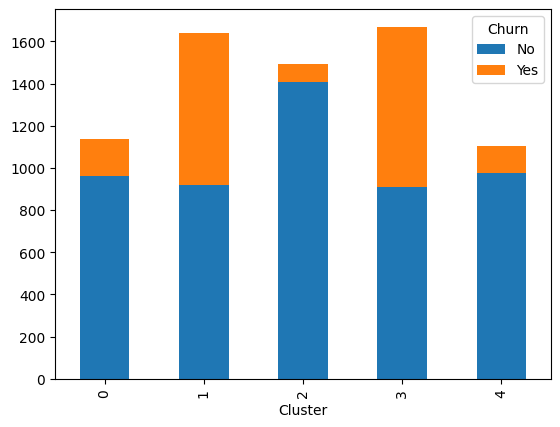

In [26]:
# Plotando um gráfico de barras com os clusters e o Churn empilhados e anotados
df_pca.groupby(['Cluster', 'Churn']).size().unstack().plot(kind='bar', stacked=True)

In [ ]:
dataframe_telco['Cluster'] = model.labels_


In [ ]:
dataframe_telco.groupby(['Cluster', 'Internet Service']).size().unstack().plot(kind='bar', stacked=True)

In [ ]:
dataframe_telco.groupby(['Cluster', 'Phone Service']).size().unstack().plot(kind='bar', stacked=True)